In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [2]:
!kaggle datasets download -d azharn/alligator-vs-crocodile1

 99%|███████████████████████████████████████▋| 171M/172M [00:07<00:00, 21.5MB/s]
100%|████████████████████████████████████████| 172M/172M [00:07<00:00, 24.7MB/s]


In [2]:
!unzip -q alligator-vs-crocodile1.zip

In [4]:
!rename "alligator vs crocodile" train

In [8]:
!mkdir validation\alligator
!mkdir validation\crocodile

In [9]:
import random
import shutil

source_folder = 'train/alligator'
target_folder = 'validation/alligator'

file_list = os.listdir(source_folder)

move_count = int(len(file_list) * 0.2)

random_files = random.sample(file_list, move_count)
for file_name in random_files:
    source_path = os.path.join(source_folder, file_name)
    target_path = os.path.join(target_folder, file_name)
    shutil.move(source_path, target_path)

In [10]:
import random
import shutil

source_folder = 'train/crocodile'
target_folder = 'validation/crocodile'

file_list = os.listdir(source_folder)

move_count = int(len(file_list) * 0.2)

random_files = random.sample(file_list, move_count)
for file_name in random_files:
    source_path = os.path.join(source_folder, file_name)
    target_path = os.path.join(target_folder, file_name)
    shutil.move(source_path, target_path)

In [11]:
data_transforms = {
    'train': transforms.Compose([
        # 크기 재조정
        transforms.Resize((224, 224)),
        # 각도, 찌그러뜨림, 크기,
        transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
        # RandomHorizontalFlip: 수평으로 뒤집기
        transforms.RandomHorizontalFlip(),
        # tensor로 전환
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [12]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [13]:
image_datasets = {
    'train': datasets.ImageFolder('train', data_transforms['train'], target_transform = target_transforms),
    'validation': datasets.ImageFolder('validation', data_transforms['validation'], target_transform = target_transforms)
}

In [14]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size = 70,
        shuffle = True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size = 70,
        shuffle = True
    )
}

In [15]:
print(len(image_datasets['train']), len(image_datasets['validation']))

2964 740


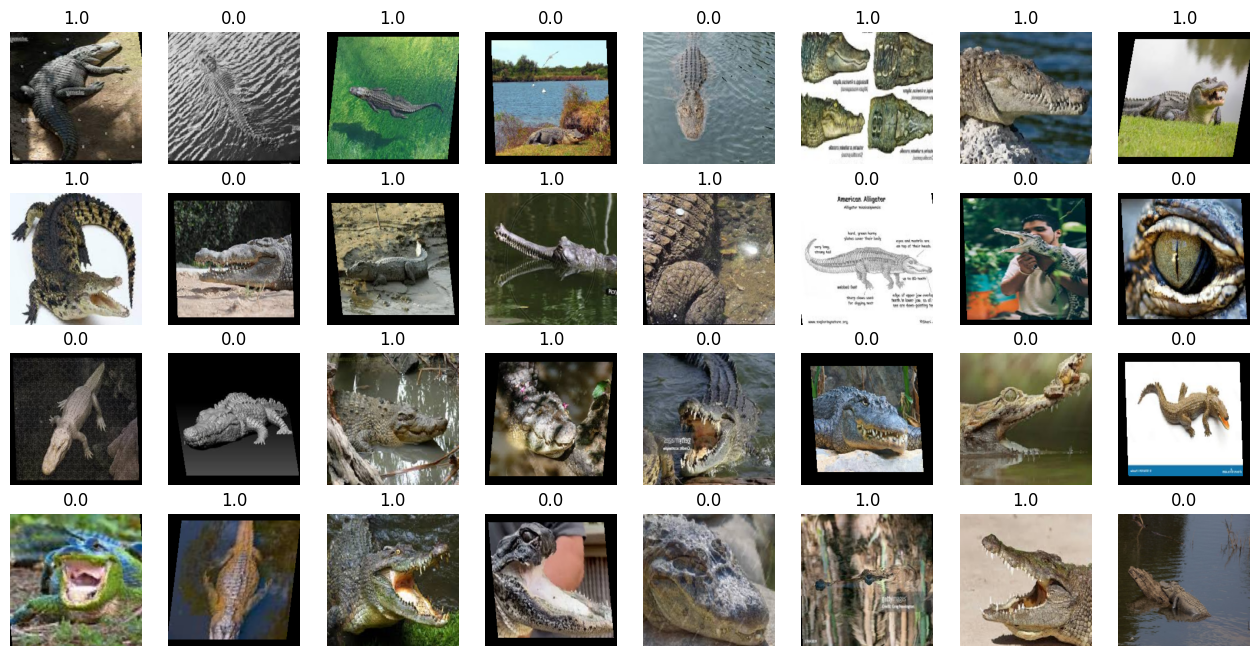

In [16]:
imgs, labels = next(iter(dataloaders['train']))

_, axes = plt.subplots(4, 8, figsize = (16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(label.item())
    ax.axis('off')

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model = efficientnet_b4(weights="DEFAULT").to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to C:\Users\selfhiam/.cache\torch\hub\checkpoints\efficientnet_b4_rwightman-23ab8bcd.pth
31.5%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

97.1%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
for param in model.parameters():
    # 가져온 파라미터(W, b)를 업데이트 하지 않음
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1792, 512),
    nn.ReLU(),

    nn.Linear(512, 48),
    nn.ReLU(),

    nn.Linear(48, 16),
    nn.ReLU(),
    
    nn.Linear(16, 1),
    nn.Sigmoid()
).to(device)

In [20]:
# 학습
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()

        else :
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss:{avg_loss:.4f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10 Loss:0.6937 Accuracy: 48.80%
validation: Epoch    1/10 Loss:0.6909 Accuracy: 58.67%
train     : Epoch    2/10 Loss:0.6880 Accuracy: 60.72%
validation: Epoch    2/10 Loss:0.6839 Accuracy: 63.44%
train     : Epoch    3/10 Loss:0.6769 Accuracy: 63.41%
validation: Epoch    3/10 Loss:0.6692 Accuracy: 63.73%
train     : Epoch    4/10 Loss:0.6587 Accuracy: 65.04%
validation: Epoch    4/10 Loss:0.6521 Accuracy: 64.84%
train     : Epoch    5/10 Loss:0.6400 Accuracy: 66.67%
validation: Epoch    5/10 Loss:0.6399 Accuracy: 65.84%
train     : Epoch    6/10 Loss:0.6237 Accuracy: 66.76%
validation: Epoch    6/10 Loss:0.6335 Accuracy: 65.03%
train     : Epoch    7/10 Loss:0.6207 Accuracy: 67.00%
validation: Epoch    7/10 Loss:0.6284 Accuracy: 65.55%
train     : Epoch    8/10 Loss:0.6129 Accuracy: 67.70%
validation: Epoch    8/10 Loss:0.6298 Accuracy: 64.48%
train     : Epoch    9/10 Loss:0.6081 Accuracy: 68.56%
validation: Epoch    9/10 Loss:0.6205 Accuracy: 65.29%
train     